# Single-objective and Multi-objective Bayesian optimization for a retention modelling toy example

In this tutorial, we illustrate how to implement the single-objective and multi-objective BO algorithms. It closely follows the toy retention modelling experiment shown in Section 4.5 of [Closed-loop automatic gradient design for liquid chromatography using Bayesian optimization](https://chemrxiv.org/engage/chemrxiv/article-details/62e2a383e7fc8f9e388caabc). 

Here we are using the [BoFire](https://github.com/experimental-design/bofire) library for the optimization:

## Imports

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List


from rm_code.crf import capped_sum_of_resolutions
from rm_code.retention_model import compute_chromatogram
from rm_code.plot_chromatogram import plot_chromatogram


from bofire.data_models.domain.api import Domain, Inputs, Outputs, Constraints
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.constraints.api import LinearInequalityConstraint
from bofire.benchmarks.api import Benchmark
from bofire.data_models.objectives.api import MaximizeObjective, MinimizeObjective
from bofire.data_models.strategies.api import RandomStrategy, SoboStrategy, MoboStrategy
import bofire.strategies.api as strategies
from bofire.runners.api import run
from bofire.utils.multiobjective import compute_hypervolume, get_pareto_front



## Setup a BoFire Benchmark Object

In BoFire, the optimization problem is defined within the `Domain` object, as BoFire is able to deal both for random sampling as for BO among others with linear inequality constraints, we set up the requirement that $t_i > t_{i-1}$ and $\phi_i > \phi_{i-1}$
as linear inequalities of the form $t_{i-1} - t_{i} < 0.01$ and  $\phi_{i-1} - \phi_{i} < 0$. 
By using this choice, there is no need for a special kernel to ensure permutation invariance.

In [112]:

class HPLC(Benchmark):

    def __init__(self, n_gradients, multiobjective = False):
        super().__init__(outlier_rate=0, outlier_prior=None)
        self.n_gradients = n_gradients
        outputs = [ContinuousOutput(key="resolution", objective=MaximizeObjective())]
        if multiobjective:
            outputs.append(ContinuousOutput(key="ctime", objective=MinimizeObjective()))
        self._domain = Domain(
            inputs=Inputs(
                features=[ContinuousInput(key=f"t_{i+1}", bounds=(0.01, 59.9)) for i in range(n_gradients)]+[ContinuousInput(key=f"phi_{i+1}", bounds=(0.01, 1)) for i in range(n_gradients)]
            ),
            constraints=Constraints(
                constraints=
                    [LinearInequalityConstraint(features=[f"t_{i+2}",f"t_{i+1}"], coefficients=[-1.,1.], rhs=-0.01) for i in range(n_gradients-1)]+[LinearInequalityConstraint(features=[f"phi_{i+2}",f"phi_{i+1}"], coefficients=[-1.,1.], rhs=0) for i in range(n_gradients-1)],
            ),
            outputs=Outputs(
                features=outputs,
            )
        )
        
        ret_pars = np.loadtxt('data/RetentionParams_Section4.5.txt') # retention parameters from example in Section 4.5
        self.k0_list = np.exp(ret_pars[:,0])
        self.S_list = ret_pars[:,1]
        # Set some default parameters
        self.t_0 = 0.8 # dead time 
        self.t_D = 0.8 # dwell time
        self.N = 1000 # plate number
        self.t_init = 0 # init time

    @property
    def ts(self) -> List[str]:
        return [f"t_{i+1}"for i in range(self.n_gradients)]
    
    @property
    def phis(self) -> List[str]:
        return [f"phi_{i+1}"for i in range(self.n_gradients)]
    
    def plot_chromatogram(self, candidate:pd.Series):
        phi_list_ms = [0.0] + candidate[self.phis].tolist() + [1.0]
        t_list_ms = [0.0] + candidate[self.ts].tolist() + [60.0]
        tR_list, W_list = compute_chromatogram(self.k0_list, self.S_list, self.t_0, self.t_D, self.t_init, phi_list_ms, t_list_ms, self.N)
        score_lin = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5)
        # compute time score, i.e. time of last eluting peak.
        time_score_lin = np.max(tR_list)
        plot_chromatogram(tR_list, W_list, phi_list_ms, t_list_ms, self.t_D, self.t_0, self.t_init)
        print(f"resolution: {score_lin}")
        print(f"time: {time_score_lin}")
        return score_lin, time_score_lin


    def _f(self, candidates: pd.DataFrame) -> pd.DataFrame:
        data = {
            "resolution": [],
            "valid_resolution": [],
            "ctime": [],
            "valid_ctime": [],
        }
        for i, row in candidates.iterrows():
            phi_list_ms = [0.0] + row[self.phis].tolist() + [1.0]
            t_list_ms = [0.0] + row[self.ts].tolist() + [60.0]
            #print(phi_list_ms)
            #print(t_list_ms)
            tR_list, W_list = compute_chromatogram(self.k0_list, self.S_list, self.t_0, self.t_D, self.t_init, phi_list_ms, t_list_ms, self.N)
            score_lin = capped_sum_of_resolutions(tR_list, W_list, max_time=60, min_res=0, max_res=1.5)
            # compute time score, i.e. time of last eluting peak.
            time_score_lin = np.max(tR_list)
            data["resolution"].append(score_lin)
            data["valid_resolution"].append(1)
            data["ctime"].append(time_score_lin)
            data["valid_ctime"].append(1)
        return pd.DataFrame.from_dict(data=data)


## Perform random sampling to show that constraints are accepted.

In [123]:
hplc = HPLC(n_gradients=4)

strategy_data = RandomStrategy(domain=hplc.domain)
sampler = strategies.map(strategy_data)
candidates = sampler.ask(5)
experiments = hplc.f(candidates=candidates, return_complete=True)
display(experiments)

,phi_1,phi_2,phi_3,phi_4,t_1,t_2,t_3,t_4,resolution,valid_resolution,ctime,valid_ctime
0,0.172478,0.640509,0.673015,0.907646,48.067019,51.521248,54.824821,57.820509,7.191593,1,66.960302,1
1,0.137317,0.369598,0.379740,0.957261,37.852850,45.370752,56.839724,57.659734,7.363600,1,67.500975,1
2,0.118635,0.269714,0.596916,0.662849,32.071996,35.820986,43.552467,58.224754,6.688774,1,67.622343,1
3,0.035659,0.333577,0.601476,0.884403,35.935582,37.256737,40.570246,53.629587,10.500192,1,62.499117,1
4,0.073827,0.315476,0.508881,0.841669,24.925009,47.513712,56.784177,57.776073,5.487101,1,68.117540,1


## Handpicked gradient program to serve as baseline

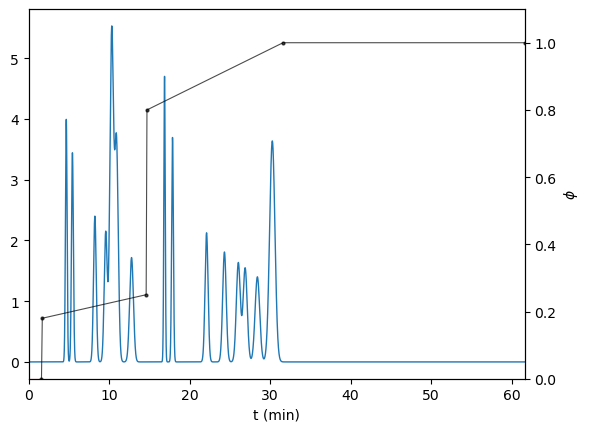

resolution: 12.730314412317586
time: 30.402499679605615


In [113]:
# plot baseline
hplc = HPLC(n_gradients=4)
baseline = pd.Series(
    data = {
        "phi_1": 0.18,
        "phi_2": 0.25,
        "phi_3": 0.8,
        "phi_4": 1.,
        "t_1": 0.1,
        "t_2": 13,
        "t_3": 13.1,
        "t_4": 30.
    }
)
baseline_resolution, baseline_ctime = hplc.plot_chromatogram(baseline)

## Optimization

### Singleobjective Optimization

Here we run a singeobjective optimization in which we want to maximize *just* the resolution. We run 10 campaigns of random sampling, consisting each of 35 samples and again 10 campaigns of BO (GP+qLognei). The first 10 samples of a BO campaign are agains sampled randomly.

#### Random Sampling

In [114]:
def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

def best(domain: Domain, experiments: pd.DataFrame) -> float:
    return experiments.resolution.max()

rresults = []

for i in range(10):
    results = random_results = run(
        hplc,
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
        n_iterations=25,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    rresults.append(results[0])

run 00 with current best 12.901: 100%|██████████| 25/25 [00:01<00:00, 14.34it/s]


#### Bayesian Optimization

In [52]:
def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

def best(domain: Domain, experiments: pd.DataFrame) -> float:
    return experiments.resolution.max()


sresults = []

for i in range(10):
    results = random_results = run(
        hplc,
        strategy_factory=lambda domain: strategies.map(SoboStrategy(domain=domain)),
        n_iterations=25,
        metric=best,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    sresults.append(results[0])

run 00 with current best 13.246: 100%|██████████| 25/25 [01:22<00:00,  3.29s/it]


#### Plot the results

Here we plot the results averaged over the 10 independent runs per optimizer (random vs BO). Note that we only show in the graph the results starting from iteration 11 in which we switched in the BO case from random sampling to BO.

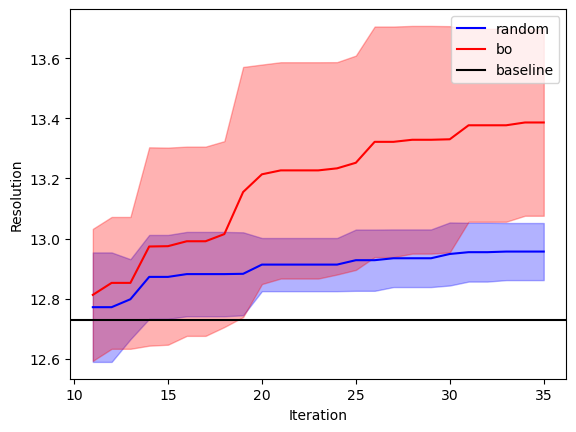

In [117]:
fig, ax = plt.subplots()

best_random = np.array([rresults[i][1] for i in range(len(rresults))])
ax.plot(range(11, 36), best_random.mean(axis=0), color="blue", label="random")
ax.fill_between(range(11, 36),(best_random.mean(0)-best_random.std(0)), (best_random.mean(0)+best_random.std(0)), alpha = 0.3, color = 'blue')

best_sobo = np.array([sresults[i][1] for i in range(len(sresults))])
ax.plot(range(11, 36), best_sobo.mean(axis=0), color="red", label="bo")
ax.fill_between(range(11, 36),(best_sobo.mean(0)-best_sobo.std(0)), (best_sobo.mean(0)+best_sobo.std(0)), alpha = 0.3, color = 'red')

ax.axhline(baseline_resolution, color="black", label="baseline")

ax.set_xlabel("Iteration")
ax.set_ylabel("Resolution")
ax.legend()

plt.show()

### Multiobjective Optimization

Here we run a multiobjective optimization in which we want to maximize the resolution and minimize the needed time. We run 10 campaigns of random sampling, consisting each of 35 samples and again 10 campaigns of MOBO (GP+qLognehvi). The first 10 samples of a BO campaign are agains sampled randomly. The reference point is chosen via the workst performance of the original singleobjective random sampling, but BoFire is also able to infer it from the training data, if not provided.

#### Random sampling

In [119]:
ref_point={"resolution": min([i[0].resolution.min() for i in rresults]), "ctime": max([i[0].ctime.max() for i in rresults])}
print(ref_point)


def hypervolume(domain: Domain, experiments: pd.DataFrame) -> float:
    return compute_hypervolume(
        domain, experiments, ref_point=ref_point
    )

def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

mo_rresults = []

for i in range(10):
    results = random_results = run(
        HPLC(n_gradients=4, multiobjective=True),
        strategy_factory=lambda domain: strategies.map(RandomStrategy(domain=domain)),
        n_iterations=25,
        metric=hypervolume,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    mo_rresults.append(results[0])

{'resolution': 4.690001107444303, 'ctime': 69.51120762506224}


run 00 with current best 337.590: 100%|██████████| 25/25 [00:01<00:00, 13.68it/s]


#### Bayesian Optimization

In [69]:
ref_point={"resolution": min([i[0].resolution.min() for i in rresults]), "ctime": max([i[0].ctime.max() for i in rresults])}

def hypervolume(domain: Domain, experiments: pd.DataFrame) -> float:
    return compute_hypervolume(
        domain, experiments, ref_point=ref_point
    )

def sample(domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

mo_sresults = []

for i in range(10):
    results = random_results = run(
        HPLC(n_gradients=4, multiobjective=True),
        strategy_factory=lambda domain: strategies.map(MoboStrategy(domain=domain, ref_point=ref_point)),
        n_iterations=25,
        metric=hypervolume,
        initial_sampler=sample,
        n_runs=1,
        n_procs=1,
    )
    mo_sresults.append(results[0])

run 00 with current best 448.490: 100%|██████████| 25/25 [05:03<00:00, 12.14s/it]


#### Plot the results
##### Performance Comparison

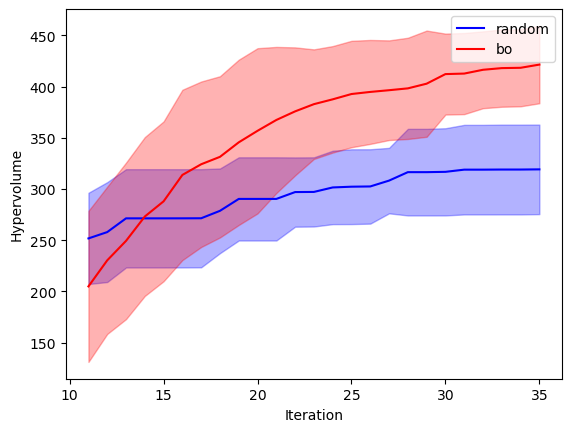

In [120]:
fig, ax = plt.subplots()

best_random = np.array([mo_rresults[i][1] for i in range(len(mo_rresults))])
ax.plot(range(11, 36), best_random.mean(axis=0), color="blue", label="random")
ax.fill_between(range(11, 36),(best_random.mean(0)-best_random.std(0)), (best_random.mean(0)+best_random.std(0)), alpha = 0.3, color = 'blue')

best_sobo = np.array([mo_sresults[i][1] for i in range(len(mo_sresults))])
ax.plot(range(11, 36),best_sobo.mean(axis=0), color="red", label="bo")
ax.fill_between(range(11, 36),(best_sobo.mean(0)-best_sobo.std(0)), (best_sobo.mean(0)+best_sobo.std(0)), alpha = 0.3, color = 'red')


ax.set_xlabel("Iteration")
ax.set_ylabel("Hypervolume")
ax.legend()

plt.show()

##### Pareto Front

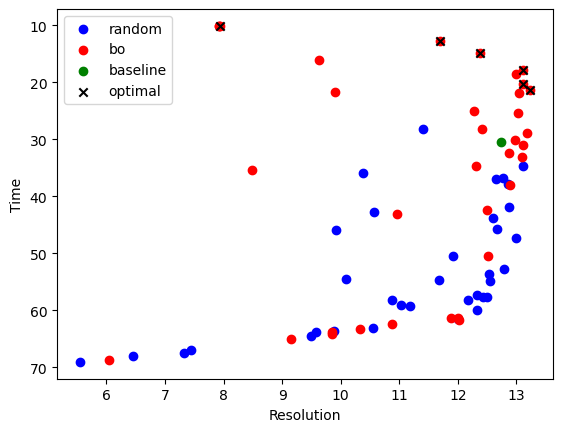

In [121]:
optimal = get_pareto_front(HPLC(n_gradients=4, multiobjective=True).domain,pd.concat([mo_rresults[-1][0], mo_sresults[-1][0]],axis=0))

fig, ax = plt.subplots()

ax.scatter(mo_rresults[-1][0].resolution,mo_rresults[-1][0].ctime*-1, color="blue", label="random")
ax.scatter(mo_sresults[-1][0].resolution,mo_sresults[-1][0].ctime*-1, color="red", label="bo")
ax.scatter(baseline_resolution, baseline_ctime*-1, color="green", label="baseline")
ax.scatter(optimal.resolution,optimal.ctime*-1, color="black", marker="x", label="optimal")

ax.legend()

ax.set_xlabel("Resolution")
ax.set_ylabel("Time")

#labels = [i for i in ax.get_yticklabels()]
ax.set_yticks([-70, -60, -50, -40, -30, -20, -10])
ax.set_yticklabels(["70", "60", "50", "40", "30", "20", "10"])

plt.show()

Here we show the six paretooptimal chromatograms together with their gradient profiles.

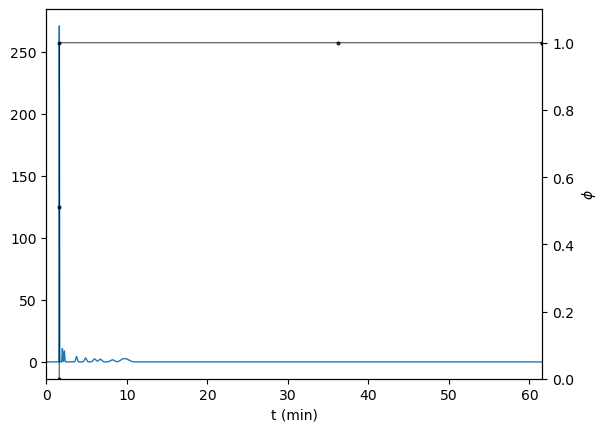

resolution: 7.934091450725623
time: 10.118295921727064


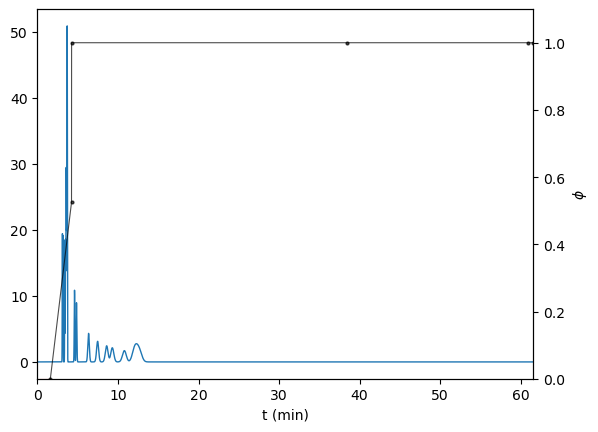

resolution: 11.699928252676337
time: 12.700082652577713


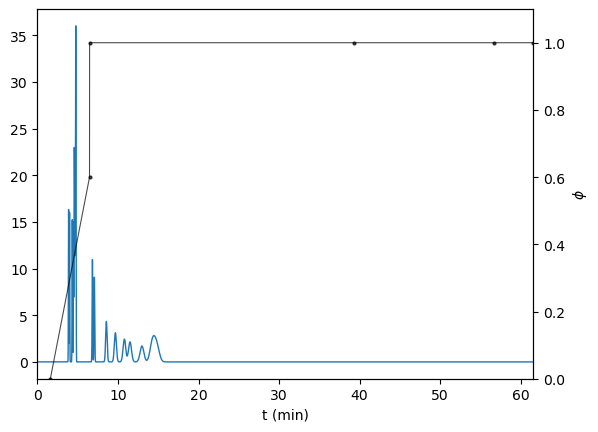

resolution: 12.38517046548872
time: 14.875200887462924


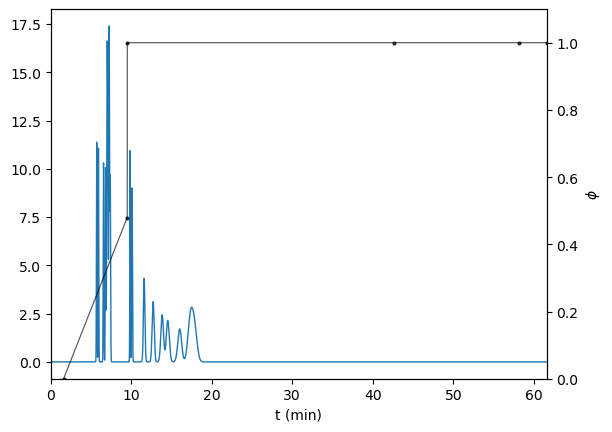

resolution: 13.109686399447224
time: 17.91886676070864


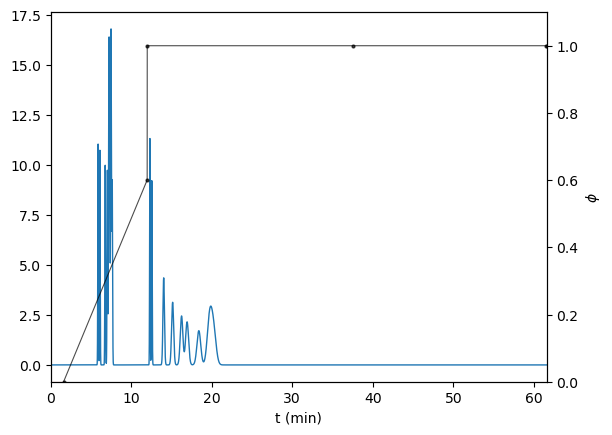

resolution: 13.117561423026702
time: 20.27756165062801


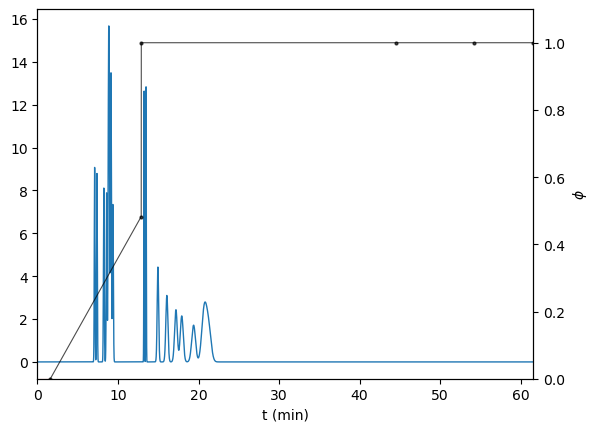

resolution: 13.239140275762685
time: 21.289730939921505


In [106]:
for i, row in optimal.sort_values(by="ctime").iterrows():
    hplc.plot_chromatogram(row)